Biến động về số ca nhiễm Covid-19 trên thế giới
    Province/State      Country/Region        Lat  ...  1/17/22  1/18/22  1/19/22
0              NaN         Afghanistan  33.939110  ...   158826   158974   159070
1              NaN             Albania  41.153300  ...   233654   236486   239129
2              NaN             Algeria  28.033900  ...   226749   227559   228918
3              NaN             Andorra  42.506300  ...    29888    29888    29888
4              NaN              Angola -11.202700  ...    93974    94275    94779
..             ...                 ...        ...  ...      ...      ...      ...
275            NaN             Vietnam  14.058324  ...  2023546  2062128  2078087
276            NaN  West Bank and Gaza  31.952200  ...   476328   477151   478084
277            NaN               Yemen  15.552727  ...    10352    10408    10449
278            NaN              Zambia -13.133897  ...   296817   298032   299172
279            NaN            Zimbabwe -19.015438 

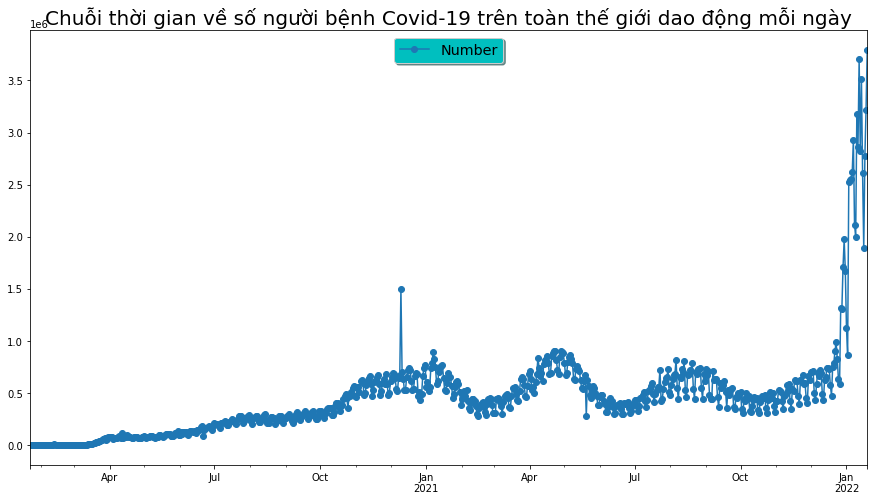

In [ ]:
import pandas as pd
import datetime
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
#Tạo data
link = 'https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_confirmed_global.csv&filename=time_series_covid19_confirmed_global.csv'
data_confirmed = pd.read_csv(link, header=0)
print('Biến động về số ca nhiễm Covid-19 trên thế giới')
print(data_confirmed )
date = [i for i in data_confirmed.columns[4:]]
sum_of_global = [sum(data_confirmed[i]) for i in data_confirmed.columns[4:]]
series_confirmed = pd.DataFrame(sum_of_global, columns=['Number'], index=date)
series_confirmed.index = pd.to_datetime(series_confirmed.index.str.split().str[0], format='%m/%d/%y')
series_confirmed.Number=series_confirmed-series_confirmed.shift()
series_confirmed = series_confirmed.dropna()
print('Thống kê số ca nhiễm Covid-19 hằng ngày trên thế giới')
print(series_confirmed)
def create_data(data, look_back):
    data_frame = data
    cols = ['X']
    for i in range(look_back):
        data_frame = pd.merge(data_frame, data.shift(i+1), how = 'left', left_index = True, right_index = True)
        cols.append('X%s'%(i+1))
    data_frame.columns = cols
    data_frame=data_frame.rename(columns = {'X':'y'})
    return data_frame.iloc[look_back:, :]
#data_description
series_confirmed.plot(figsize = (15,8), style = 'o-', label = 'Y')
plt.title('Chuỗi thời gian về số người bệnh Covid-19 trên toàn thế giới dao động mỗi ngày', fontsize=20)
legend = plt.legend(loc = 'upper center', shadow = True, fontsize = 'x-large')
legend.get_frame().set_facecolor('C')
print('Thống kê mô tả')
print(series_confirmed.describe())
#creat_series_shift
look_back = 1
data_series_confirmed = create_data(series_confirmed, 1)
scaler = MinMaxScaler(feature_range = (0, 1))
data_series_scaler_confirmed = scaler.fit_transform(data_series_confirmed)
#split into train and test sets
train_size_confirmed = int(data_series_confirmed.shape[0]*0.7)
test_size_confirmed = data_series_confirmed.shape[0] - train_size_confirmed
train_confirmed, test_confirmed = data_series_scaler_confirmed[0:train_size_confirmed, :], data_series_scaler_confirmed[train_size_confirmed:data_series_confirmed.shape[0], :]
#print('Kích thước Train:',train_confirmed.shape)
#print('Kích thước Test:',test_confirmed.shape)
trainX_confirmed, trainY_confirmed = train_confirmed[:, 1:], train_confirmed[:, 0]
testX_confirmed, testY_confirmed = test_confirmed[:, 1:], test_confirmed[:, 0]
# reshape input to be [samples, time steps, features]
trainX_confirmed = trainX_confirmed.reshape(trainX_confirmed.shape[0], 1, trainX_confirmed.shape[1])
testX_confirmed = testX_confirmed.reshape(testX_confirmed.shape[0], 1, testX_confirmed.shape[1])

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

model = Sequential()
model.add(LSTM(5, input_shape = (1, look_back)))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')
model.fit(trainX_confirmed, trainY_confirmed, epochs = 500, batch_size = 25, verbose = 0, shuffle = False)

Train MSE: 22104.82471211902
Test MSE: 393567.0403728905
Kích thước Train: 508
Kích thước Test: 508


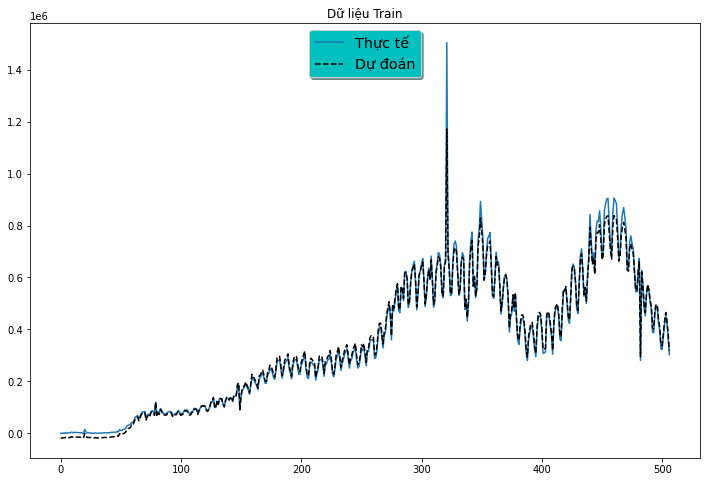

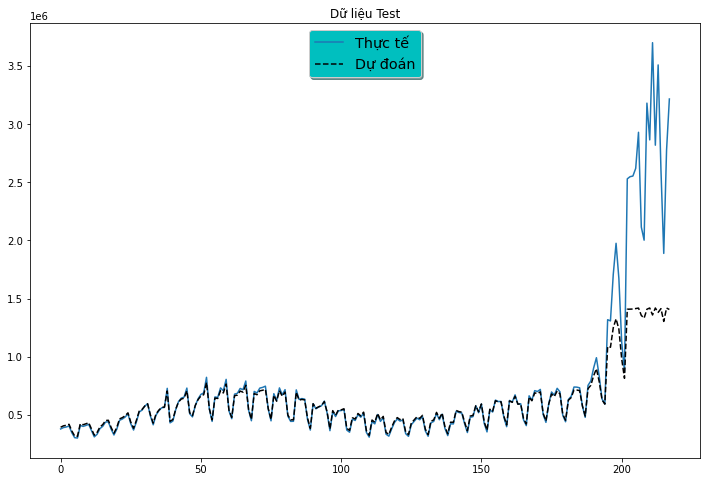

In [ ]:
# Make prediction
trainPredict_confirmed = model.predict(trainX_confirmed)
testPredict_confirmed = model.predict(testX_confirmed)
# Invert prediction
trainPredictInv_confirmed = scaler.inverse_transform(np.concatenate((trainPredict_confirmed, trainX_confirmed.reshape(trainX_confirmed.shape[0], -1)), axis = 1))[:, 0]
trainYInv_confirmed = data_series_confirmed.iloc[:train_size_confirmed, 0].values
testPredictInv_confirmed = scaler.inverse_transform(np.concatenate((testPredict_confirmed, testX_confirmed.reshape(testX_confirmed.shape[0], -1)), axis = 1))[:, 0]
testYInv_confirmed = data_series_confirmed.iloc[train_size_confirmed:, 0].values
#Calculate MSE
mse_train_confirmed = math.sqrt(mean_squared_error(trainYInv_confirmed[:-1], trainPredictInv_confirmed[1:]))
mse_test_confirmed = math.sqrt(mean_squared_error(testYInv_confirmed[:-1], testPredictInv_confirmed[1:]))
print('Train MSE: %s' %mse_train_confirmed)
print('Test MSE: %s' %mse_test_confirmed)
#Draw train
print('Kích thước Train:',train_size_confirmed)
plt.figure(figsize = (12, 8))
plt.plot(trainYInv_confirmed[:-1], label = 'Thực tế')
plt.plot(trainPredictInv_confirmed[1:], 'k--', label = 'Dự đoán')
plt.title('Dữ liệu Train')
legend = plt.legend(loc = 'upper center', shadow = True, fontsize = 'x-large')
legend.get_frame().set_facecolor('C')
#Draw test
print('Kích thước Test:',train_size_confirmed)
plt.figure(figsize = (12, 8))
plt.plot(testYInv_confirmed[:-1], label = 'Thực tế')
plt.plot(testPredictInv_confirmed[1:], 'k--', label = 'Dự đoán')
plt.title('Dữ liệu Test')
legend = plt.legend(loc = 'upper center', shadow = True, fontsize = 'x-large')
legend.get_frame().set_facecolor('C')

    Ngày  Giá trị dự đoán
0     20     7.908640e+05
1     21     9.020640e+05
2     22     9.910900e+05
3     23     8.307090e+05
4     24     6.353320e+05
5     25     5.923260e+05
6     26     1.318209e+06
7     27     1.307699e+06
8     28     1.707946e+06
9     29     1.975516e+06
10    30     1.673559e+06
11    31     1.127574e+06
12    32     8.715430e+05
13    33     2.530174e+06
14    34     2.548784e+06
15    35     2.554214e+06
16    36     2.619998e+06
17    37     2.930632e+06
18    38     2.115158e+06
19    39     2.002402e+06
20    40     3.181541e+06
21    41     2.865332e+06
22    42     3.701647e+06
23    43     2.819653e+06
24    44     3.510266e+06
25    45     2.609185e+06
26    46     1.888487e+06
27    47     2.776856e+06
28    48     3.217191e+06
29    49     3.790099e+06
30    50     1.358791e+06


Text(0.5, 1.0, 'Dự đoán số người mắc bệnh Covid19 trên toàn thế giới dao động trong 31 ngày kế tiếp')

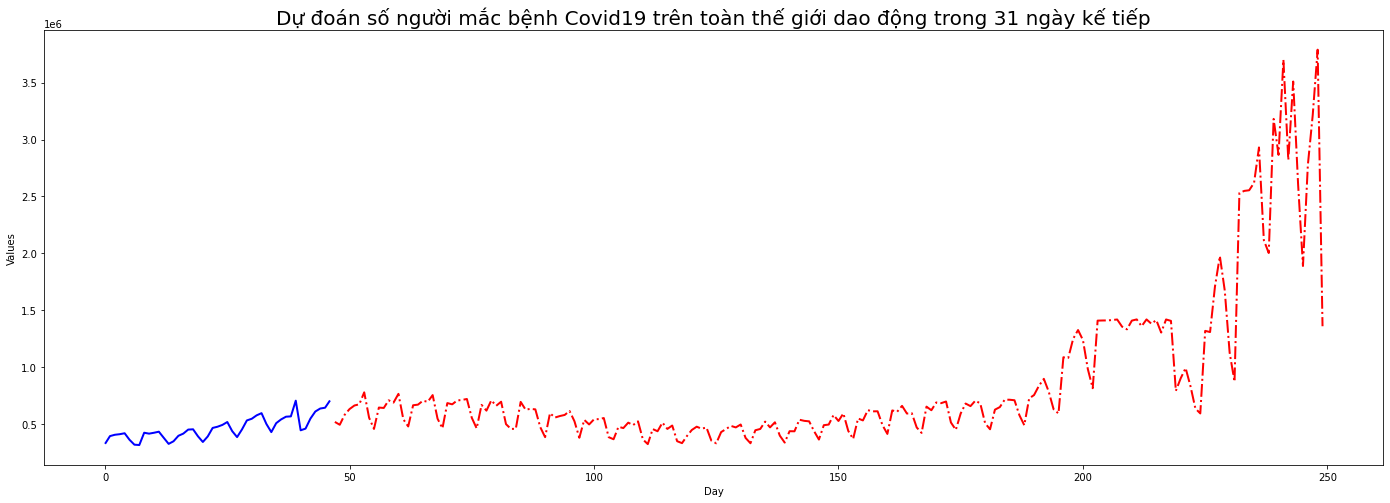

In [ ]:
import matplotlib.collections as ml
n_predict=31
look_back=1
for i in range(n_predict):
    forecastY_confirmed = testY_confirmed.reshape(-1, 1)
    Ypredict_confirmed = model.predict(forecastY_confirmed[-look_back:].reshape(1,1,look_back))
    forecastY_confirmed = np.concatenate((forecastY_confirmed, Ypredict_confirmed), axis = 0)
forecastY_confirmed = forecastY_confirmed[-(n_predict+look_back+1):]
inversePredict_confirmed = [forecastY_confirmed[-(n_predict+i):] if i == 0 else forecastY_confirmed[-(n_predict+i):-i] for i in range(look_back+1)]
inversePredict_confirmed = np.concatenate(inversePredict_confirmed, axis = 1)
Ypredict_confirmed = scaler.inverse_transform(inversePredict_confirmed)[:, 0]
date_predict=[i for i in range(data_series_confirmed[train_size_confirmed:].index[-1].day+1,data_series_confirmed[train_size_confirmed:].index[-1].day+n_predict+1)]
series_confirmed = pd.DataFrame(data={'Ngày':date_predict,'Giá trị dự đoán':Ypredict_confirmed})
print(series_confirmed)
Ymerge_confirmed = np.concatenate((testPredictInv_confirmed, Ypredict_confirmed))
Ygraph_confirmed = np.concatenate((np.arange(Ymerge_confirmed.shape[0]).reshape(Ymerge_confirmed.shape[0], -1), Ymerge_confirmed.reshape(Ymerge_confirmed.shape[0], -1)), axis = 1)
fig, ax = plt.subplots(figsize = (24, 8))
line_segments_confirmed = ml.LineCollection([Ygraph_confirmed[:47], Ygraph_confirmed[47:]], colors = ['b', 'r'], linestyle = ['solid', 'dashdot'], linewidth = 2)
ax.add_collection(line_segments_confirmed)
ax.autoscale()
ax.set_ylabel('Values')
ax.set_xlabel('Day')
plt.title('Dự đoán số người mắc bệnh Covid19 trên toàn thế giới dao động trong %d ngày kế tiếp'%Ypredict_confirmed.shape[0], fontsize = 20) 

In [ ]:
float("4.231832e+06")
# and now with 'rounding'
"{:.8f}".format(float("4.231832e+06"))

'4231832.00000000'